# **Perceptron - rice_ml**
This notebook demonstrates how to use the PerceptronClassifier within the rice_ml package. It demonstrates it in an informative way that also analyzes the results, mirroring a standard use case of the classes.

Note that when using this in robust model selection, k-fold cross-validation and deeper hyperparameter tuning is recommended. In this example, since it's main goal is demonstrating the classes, we will not do as deep of hyperparameter tuning, and will compare every test using the same random state (42).

This notebook shows how to:
- Use 'PerceptronClassifier' from 'rice_ml'
- Prepare and normalize data using 'rice_ml'
- Evaluate Perceptron on a binary classification task

## Table of Contents
- [Algorithm](#algorithm)
- [Data Preparation](#data-preparation)
- [Perceptron Classification](#perceptron-classification)
  - [Model Training](#model-training)
  - [Results](#results)

## Algorithm
A Perceptron is the simplest form of a neural network. It combines inputs with weights and bias and results in a binary prediction. It is a linear binary classifier. Its training consists of iteratively updating the weights when a sample is misclassified, and then recomputing. The updates work to reduce error. Since the perceptron learns a linear decision boundary in the original pixel space, it cannot capture nonlinear patterns such as loops or stroke curvature. It is a very simple model, but can perform suprisingly well on certain problesm with linearly separable data.


![Perceptron Example](../images/perceptron.webp)
Source: [Geeks For Geeks](https://www.geeksforgeeks.org/machine-learning/what-is-perceptron-the-simplest-artificial-neural-network/)


### Pros vs Cons
#### Pros
- Simple
- Easy to understand
- Very interpretable
- Great baseline model
#### Cons
- Limited to linear decision boundaries
- Binary classification only
- Sensitive to noise


#### Note
The perceptron is a linear classifier that learns a separating hyperplane
for binary classification tasks. It updates weights based on misclassified
samples using the perceptron learning rule. This implementation uses online
learning (one sample at a time).

The perceptron is guaranteed to converge only for linearly separable data.
For non-separable data, it will continue updating weights until `max_iter`
is reached or the tolerance criterion is met.

## Data Preparation
We will be using the MNIST digits dataset. It is a widely used benchmark for image classification. It contains 70,000 grayscale images of handwritten digits (0-9). Each image is 28x28 pixels.
For sake of runtime, we will be using a random 10,000 data point sample from the dataset.

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from rice_ml.utilities import normalize, train_test_split

np.random.seed(42)

## Given that this implementation only supports binary outputs, we will use only 4 and 9 only.
### We are using these two because they tend to look similar, and other models have shown most
### of their inaccuracies are between these two. 
X_raw, y_raw = fetch_openml(
    "mnist_784",
    version=1,
    return_X_y=True,
    as_frame=False
)

mask = (y_raw == '4') | (y_raw == '9')

X_raw = X_raw[mask]
y_raw = y_raw[mask]

## To form binary outputs
### 0 will represent '4' and 1 will represent '9'
y_raw = (y_raw == '9').astype(int)

X shape: (13782, 784)
y shape: (13782,)
X Overall Summary:
Mean: 0.122
Std: 0.298
Before normalization:
Mean (first 5 features): [0. 0. 0. 0. 0.]
Std  (first 5 features): [0. 0. 0. 0. 0.]


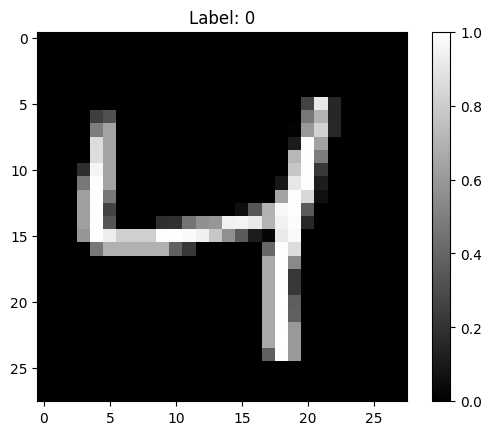

In [2]:
X = np.asarray(X_raw)
y = np.asarray(y_raw)

# Scaling
X = X / 255.0
y = y.astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)

print("X Overall Summary:")
print(f"Mean: {X.mean():.3f}")
print(f"Std: {X.std():.3f}")

print("Before normalization:")
print("Mean (first 5 features):", np.round(X.mean(axis=0)[:5], 2))
print("Std  (first 5 features):", np.round(X.std(axis=0)[:5], 2))

image = X[0].reshape(28, 28)

plt.imshow(image, cmap="gray")
plt.title(f"Label: {y[0]}")
plt.colorbar()
plt.show()

## Perceptron Classification
### Model Training

We will now fit a perceptron classifier on the above data, analyze it, and look at some potential improvements using normalization.

Perceptron Classification Accuracy: 0.958


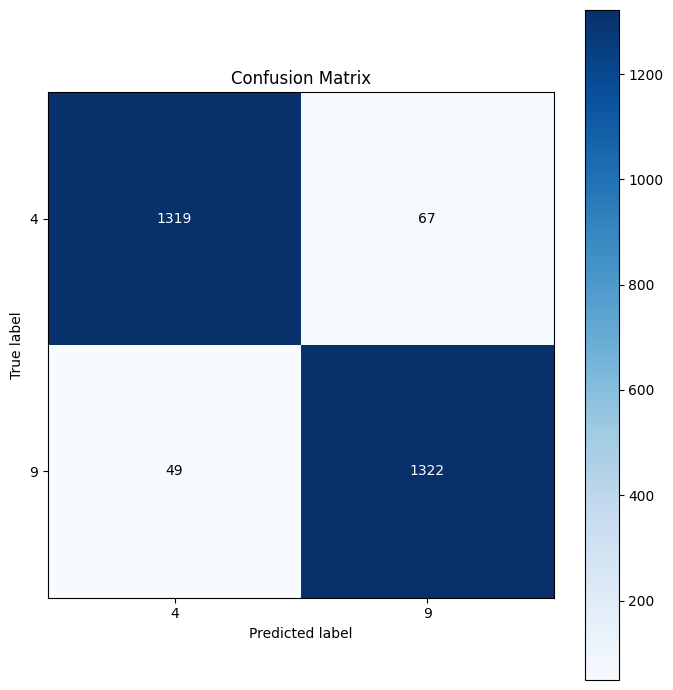

In [6]:
from rice_ml.supervised_learning.perceptron import PerceptronClassifier
from rice_ml.utilities import confusion_matrix, plot_confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Small hidden layer.
model = PerceptronClassifier(lr=0.01)

model.fit(X_train, y_train)

results = model.predict(X_test)
accuracy = model.score(X_test, y_test)

print(f"Perceptron Classification Accuracy: {accuracy:.3f}")
cm = confusion_matrix(y_test, results, num_classes=2)
plot_confusion_matrix(cm, class_labels=[4,9])


This performs surprisingly well for a linear classifier. It highlights that 4s and 9s can be linearlly separable in pixel space fairly well. It does not perform quite as well as an MLP, but it does very well with just one neuron.

Let's look at some normalization and see if it improves.

#### Z-Score Normalization

After zscore normalization:
Mean (first 5 features): [0. 0. 0. 0. 0.]
Std  (first 5 features): [0. 0. 0. 0. 0.]


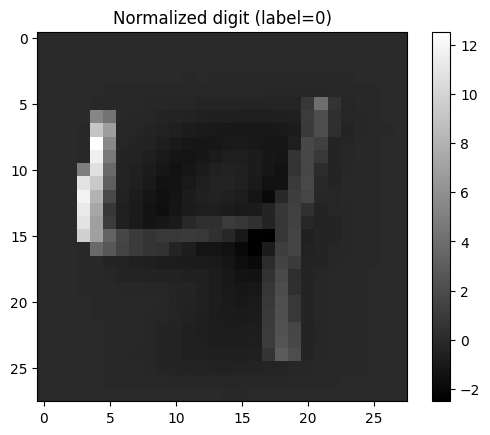

In [4]:
X = np.asarray(X)
X_norm = normalize(X, method="zscore")

print("After zscore normalization:")
print("Mean (first 5 features):", np.round(X_norm.mean(axis=0)[:5], 2))
print("Std  (first 5 features):", np.round(X_norm.std(axis=0)[:5], 2))

image_norm = X_norm[0].reshape(28, 28)

plt.imshow(image_norm, cmap="gray")
plt.title(f"Normalized digit (label={y[0]})")
plt.colorbar()
plt.show()

This normalization makes the image look darker, so it may be less well-defined. Let's see how the model does.

Perceptron Classification Accuracy: 0.959


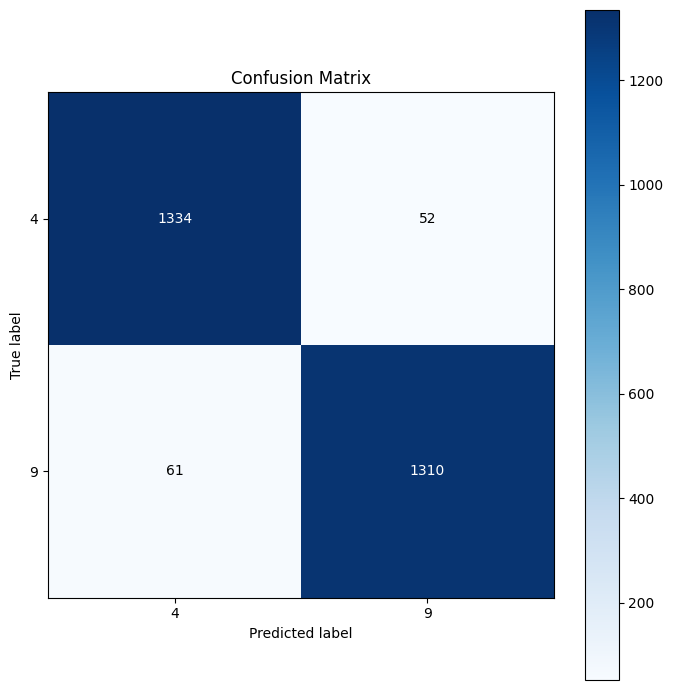

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Normalize on the training data to avoid data leakage.
X_train, stats = normalize(X_train, method="zscore", return_stats=True)
X_test = normalize(X_test, method="zscore", stats=stats)

model = PerceptronClassifier(lr=0.01)

model.fit(X_train, y_train)

results = model.predict(X_test)
accuracy = model.score(X_test, y_test)

print(f"Perceptron Classification Accuracy: {accuracy:.3f}")
cm = confusion_matrix(y_test, results, num_classes=2)
plot_confusion_matrix(cm, class_labels=[4,9])


We don't see much of a boost from the normalization in this case. The standard model performs just as well. Let's look at some l1 normalization to compare.

#### L1 Normalization

After robust normalization:
Mean (first 5 features): [0. 0. 0. 0. 0.]
Std  (first 5 features): [0. 0. 0. 0. 0.]


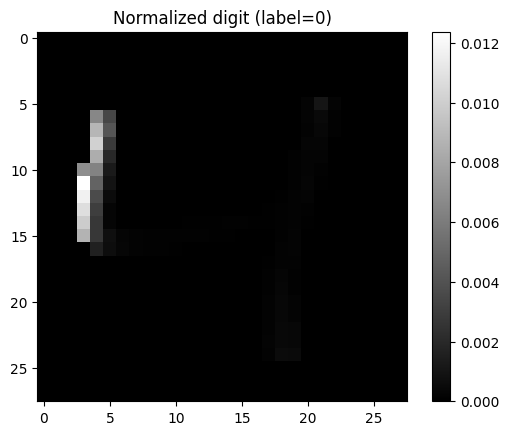

In [7]:
X = np.asarray(X)
X_norm = normalize(X, method="l1")

print("After robust normalization:")
print("Mean (first 5 features):", np.round(X_norm.mean(axis=0)[:5], 2))
print("Std  (first 5 features):", np.round(X_norm.std(axis=0)[:5], 2))

image_norm = X_norm[0].reshape(28, 28)

plt.imshow(image_norm, cmap="gray")
plt.title(f"Normalized digit (label={y[0]})")
plt.colorbar()
plt.show()

Perceptron Classification Accuracy: 0.959


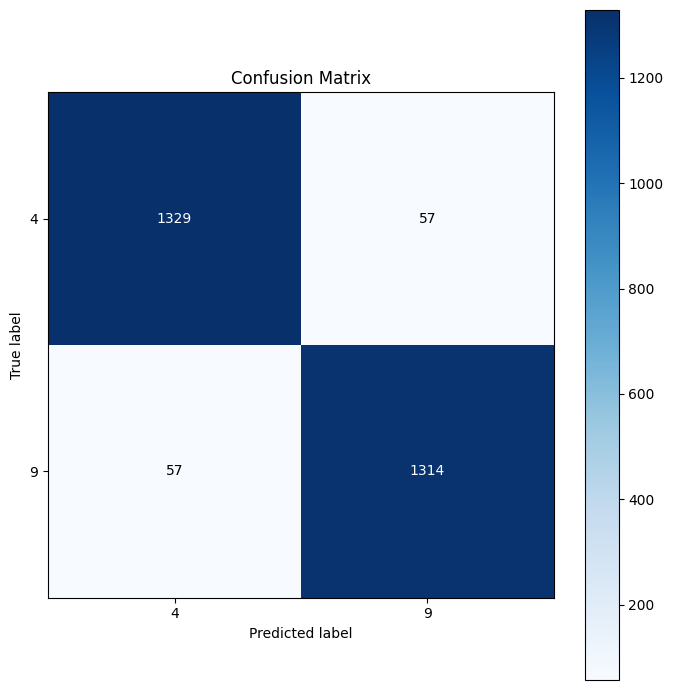

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# No need to normalize on the training data - l2 is stateless, so there is no data leakage.
X_train = normalize(X_train, method="minmax")
X_test  = normalize(X_test, method="minmax")

model = PerceptronClassifier(lr=0.01)

model.fit(X_train, y_train)

results = model.predict(X_test)
accuracy = model.score(X_test, y_test)

print(f"Perceptron Classification Accuracy: {accuracy:.3f}")
cm = confusion_matrix(y_test, results, num_classes=2)
plot_confusion_matrix(cm, class_labels=[4,9])


We see the visualization loses a lot of information for the human eye, but the model produced similar results to the base model and the zscore normalization. No stand out performances here.

### Results
Accuracy:
- Base Model: 95.8%
- Zscore Norm: 95.9%
- L1 Norm: 95.9%

There is very little difference between the models. The base model performs very well, and sees only a minor improvement in its accuracy when normalized.

#### Error Analysis

One thing to keep in mind with Perceptrons is that they are linear. There is only one neuron, so nonlinear relationships could struggle. The model did suprisingly well with '4' and '9', but it is possible that it would greatly struggle with other numbers. Overall, a multi-layered perceptron will perform better.

Below we can take a look some of the misidentified images. We can see that there are some clear misses, but a lot of the misses are very unclear or messy digits.

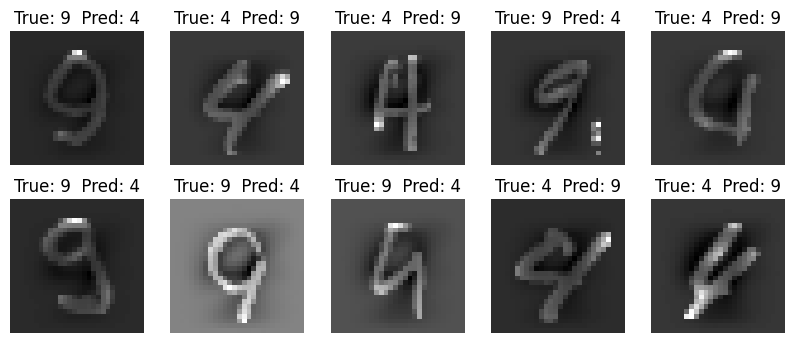

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Normalize on the training data to avoid data leakage.
X_train, stats = normalize(X_train, method="zscore", return_stats=True)
X_test = normalize(X_test, method="zscore", stats=stats)

model = PerceptronClassifier(lr=0.01)

model.fit(X_train, y_train)

results = model.predict(X_test)
accuracy = model.score(X_test, y_test)


errors = (results != y_test)
X_err = X_test[errors]
y_err = y_test[errors]
y_pred_err = results[errors]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    y_err_val = 4
    if y_err[i] == 1:
        y_err_val = 9

    y_pred_err_val = 4
    if y_pred_err[i] == 1:
        y_pred_err_val = 9
    ax.imshow(X_err[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_err_val}  Pred: {y_pred_err_val}")
    ax.axis("off")
